In [3]:
import numpy as np
from matplotlib import pyplot as plt 

from numpy.random import default_rng
rng = default_rng(seed=1234)

# Data

In [4]:
from masterthesis.data import load_h5ad

# load the python AnnData object
anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/acinar_sce.h5ad")
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/COVAC_POSTQC.h5ad")

# sampling in R with seed 1234
test_idx = [284, 336, 406, 101, 111, 393, 133, 400, 388, 98, 103, 214, 90, 326, 79, 372, 270, 382, 184, 62, 4, 403, 149, 40, 212, 195, 93, 122, 66, 175, 379, 304, 108, 131, 343, 41, 115, 228, 328, 298, 299]
train_idx = list(set(range(anndata.X.shape[0])) - set(test_idx))

# selected Genes after preprocessing in R
sel_genes = ["REG3A", "AMY2A", "MT2A", "OLFM4",
             "SYCN", "CELA2B", "FGL1", "AMY2B",
             "MT1G", "TM4SF1", "CELA2A", "PDK4", 
             "TACSTD2", "CD44", "PNLIPRP2", "ALB", 
             "ERP27", "LDHA", "REG3G", "CTRL", "CLPS",
             "FOS", "HSPA8", "SERPINA3", "CELA3B", "CRP" ]

sel_genes = sorted(sel_genes)

from sklearn.model_selection import train_test_split

y = np.array([int(x) for x in anndata.obs.donor_age])
k = len(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(anndata[:,sel_genes].X, y, 
                                                    test_size=0.1, 
                                                    stratify=y,
                                                    random_state=1234)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(369, 26)
(42, 26)
(369,)
(42,)


## Preprocessing

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Transform y into a series of subsequent labels [0,1,2 ...]
transf = dict(zip(np.unique(y),
                  np.arange(0, len(np.unique(y)))))

y_train_trans = np.array([transf[e] for e in y_train])
y_test_trans = np.array([transf[e] for e in y_test])

# reordering, such that yi < yi+1
train_reorder = np.argsort(y_train_trans)
test_reorder = np.argsort(y_test_trans)

# Predictions

In [13]:
from masterthesis.model import SGDBinarizedModel, LinearBinarizedModel
from masterthesis.metrics import abs_delta, class_error

# Fitting
lin_model = SGDBinarizedModel(regularization=0.02811).fit(X_train, y_train)

print(lin_model.beta)
print(lin_model.theta)

# Predictions
y_pred_train = lin_model.predict(X_train)

print("(Train) Mean Absolute Delta:", abs_delta(y_train_trans, y_pred_train, mean=True))
print("(Train) Class Error:", class_error(y_train_trans, y_pred_train))

y_pred_test = lin_model.predict(X_test)

print("(Test) Predictions:", y_pred_test)
print("(Test) Targets:", y_test_trans)
print("(Test) Mean Absolute Delta:", abs_delta(y_test_trans, y_pred_test, mean=True))
print("(Test) Class Error:", class_error(y_test_trans, y_pred_test))

print("(Test) Accuracy ", np.sum(y_pred_test == y_test_trans) / len(y_pred_test) )
lin_model

[ 0.          0.          0.03099886  0.11615632  0.         -0.17015261
  0.          0.          0.         -0.16155155 -0.15444206  0.00261222
  0.          0.          0.          0.          0.18441797  0.05207718
  0.05456746 -0.06037207  0.36455703 -0.21762471  0.35551376  0.
  0.          0.        ]
[-1.15925956 -0.84937043  0.          0.          0.          0.
  0.9473221 ]
(Train) Mean Absolute Delta: 1.7344173441734418
(Train) Class Error: 0.17886178861788618
(Test) Predictions: [0 6 6 0 0 6 0 6 0 6 6 6 0 0 6 0 0 0 0 6 6 0 6 0 0 0 0 0 6 6 0 0 0 0 6 0 0
 0 0 6 0 6]
(Test) Targets: [5 2 3 1 4 7 5 2 1 6 3 3 0 5 7 1 1 5 5 6 7 1 3 1 1 7 1 0 5 3 1 2 0 2 3 5 0
 5 0 1 1 3]
(Test) Mean Absolute Delta: 2.3333333333333335
(Test) Class Error: 0.16666666666666666
(Test) Accuracy  0.16666666666666666


SGDBinarizedModel(regularization=0.02811)

Why are the scores so low? Are the classes represented the same in test and training?

Text(0.5, 1.0, 'Ground Truth')

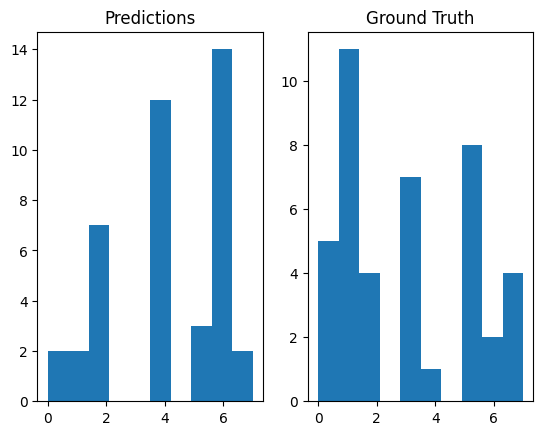

In [11]:
ax = plt.figure()
p1 = ax.add_subplot(121)
p1.hist(y_pred_test)
p1.set_title("Predictions")
p2 = ax.add_subplot(122)
p2.hist(y_test_trans)
p2.set_title("Ground Truth")

On average the abs delta is between 1-2. What is the average like, if we combine classes?